<a href="https://colab.research.google.com/github/victor-armegioiu/Learning-Bayesian-Priors/blob/main/Sliced_Score_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sliced Score Matching (https://arxiv.org/pdf/1905.07088.pdf)

In [1]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import pprint

In [2]:
data = np.random.randn(10000)

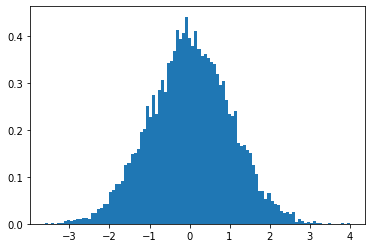

In [3]:
plt.hist(data, density=True, bins=100)
plt.show()

Implements the *sliced score estimator* objective function, and returns a trained NN, denoted as $h(\cdot, \hat{\theta})$. Ideally, given an implicit distribution represented as a set of particles (samples $x \sim p(\cdot)$), the trained model learns to predict the score function of $p$, in an unsupervised fashion, such that $\Vert h(x, \hat{\theta}) - \nabla_x \log p(x) \Vert$ is minimized. 

Note that we do this **without** access to the actual score function.
We use samples $x \sim \mathcal{N}(0, 1)$, since $\nabla_x \log p(x) = -x$ in this case, so it's easier to check for correct results just by looking at them.
See **3.2 SLICED SCORE ESTIMATION** for details.

In [4]:
tf.keras.backend.clear_session()

def GetSlicedScoreEstimator(config, print_every_n=10, verbose=False):
  """Train a NN to perform score estimation based on samples.

  @params:
    config: dict, contains training setting, the samples and the model to be  
    optimized.

    print_every_n: number of epochs to wait before printing loss info.
    verbose: Printing is done only if this is set to `True`.
  """
  x = config['data']
  score_net = config['score_net']

  # Training setup.
  epochs = config['epochs']
  lambda_reg = config['lambda_reg']
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  best_model = tf.keras.models.clone_model(score_net)
  best_loss = 1e9

  x_tensor = tf.cast(x, tf.float64)
  for epoch in range(epochs):
    with tf.GradientTape(persistent=True) as g:
      g.watch(x_tensor)
      vectors = tf.random.normal(shape=x_tensor.shape, dtype=tf.float64)
      
      grad1 = tf.cast(score_net(x_tensor), tf.float64)
      gradv = tf.math.reduce_sum(grad1 * vectors, axis=0)

      loss1 = lambda_reg * tf.math.reduce_sum(
          (grad1 * vectors) ** 2, axis=0) 

      grad2 = g.gradient(gradv, x_tensor)
      loss2 = tf.math.reduce_sum(vectors * grad2, axis=0)

      # Combine the losses.
      loss_val = tf.reduce_mean(loss1 + loss2)

    grads = g.gradient(loss_val, score_net.trainable_weights)
    optimizer.apply_gradients(zip(grads, score_net.trainable_weights))

    if loss_val.numpy() < best_loss:
      best_loss = loss_val.numpy()
      best_model.set_weights(score_net.get_weights())

    if verbose and epoch % print_every_n == 0:
      print('Epoch [%d], loss: [%f]' % (epoch, loss_val.numpy(),))

  return best_model, best_loss
    

In [5]:
input_shape = (1,)
score_net = tf.keras.Sequential([
    tf.keras.Input(shape=input_shape, name='input'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(input_shape[0]),
])

config = {'data': data[:, None],
          'score_net': score_net,
          'epochs': 1000, 
          'lambda_reg': 0.15
}

best_score_estimator, best_loss = GetSlicedScoreEstimator(config, verbose=True)

Epoch [0], loss: [-1707.479708]
Epoch [10], loss: [-1913.203701]
Epoch [20], loss: [-2093.652093]
Epoch [30], loss: [-2365.111260]
Epoch [40], loss: [-2515.873124]
Epoch [50], loss: [-2749.246060]
Epoch [60], loss: [-2690.968213]
Epoch [70], loss: [-2970.881006]
Epoch [80], loss: [-3159.448414]
Epoch [90], loss: [-3180.307620]
Epoch [100], loss: [-3420.451418]
Epoch [110], loss: [-3599.202437]
Epoch [120], loss: [-3722.238804]
Epoch [130], loss: [-3778.214210]
Epoch [140], loss: [-4031.416459]
Epoch [150], loss: [-4091.968501]
Epoch [160], loss: [-4389.781549]
Epoch [170], loss: [-4493.239384]
Epoch [180], loss: [-4503.510026]
Epoch [190], loss: [-4740.960536]
Epoch [200], loss: [-4597.640830]
Epoch [210], loss: [-4991.424514]
Epoch [220], loss: [-5207.473622]
Epoch [230], loss: [-5437.842315]
Epoch [240], loss: [-5443.153971]
Epoch [250], loss: [-5629.808508]
Epoch [260], loss: [-5754.116041]
Epoch [270], loss: [-5773.548479]
Epoch [280], loss: [-5971.231381]
Epoch [290], loss: [-5991

In [6]:
print('Lowest loss:', best_loss)

Lowest loss: -6962.4145226680985


In [12]:
test_data = np.random.randn(5)
scores = best_score_estimator.predict(test_data[:, None])
scores = [score[0] for score in scores]

pprint.pprint(list(zip(test_data, scores)))


[(0.08620048598248987, -0.07383168),
 (-0.38355502449083445, -0.04168506),
 (3.058310617341467, -3.6396065),
 (-1.188687658138537, 0.6873603),
 (2.4908088889753377, -2.6998122)]


Optimally, the plotted points would fall on the same line (this only holds for a unit variance, $0$-mean, univariate Gaussian distribution), and the scales would be the same on both axes.

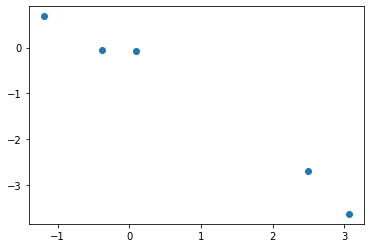

In [13]:
plt.scatter(test_data, scores)
plt.show()